# LogisticRegression and Clustering

A logistic regression implements a convex partition of the features spaces. A clustering algorithm applied before the trainer modifies the feature space in way the partition is not necessarily convex in the initial features. Let's see how. 

In [1]:
from jyquickhelper import add_notebook_menu

add_notebook_menu()

In [2]:
%matplotlib inline

## A dummy datasets and not convex

In [3]:
import numpy
import numpy.random

Xs = []
Ys = []
n = 20
for i in range(0, 5):
    for j in range(0, 4):
        x1 = numpy.random.rand(n) + i * 1.1
        x2 = numpy.random.rand(n) + j * 1.1
        Xs.append(numpy.vstack([x1, x2]).T)
        cl = numpy.random.randint(0, 4)
        Ys.extend([cl for i in range(n)])
X = numpy.vstack(Xs)
Y = numpy.array(Ys)
X.shape, Y.shape, set(Y)

((400, 2), (400,), {0, 1, 2, 3})

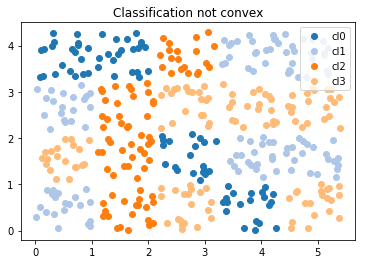

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
for i in set(Y):
    ax.plot(
        X[Y == i, 0], X[Y == i, 1], "o", label="cl%d" % i, color=plt.cm.tab20.colors[i]
    )
ax.legend()
ax.set_title("Classification not convex");

## One function to plot classification in 2D

In [5]:
import matplotlib.pyplot as plt


def draw_border(
    clr,
    X,
    y,
    fct=None,
    incx=1,
    incy=1,
    figsize=None,
    border=True,
    clusters=None,
    ax=None,
):
    # see https://sashat.me/2017/01/11/list-of-20-simple-distinct-colors/
    # https://matplotlib.org/examples/color/colormaps_reference.html
    _unused_ = [
        "Red",
        "Green",
        "Yellow",
        "Blue",
        "Orange",
        "Purple",
        "Cyan",
        "Magenta",
        "Lime",
        "Pink",
        "Teal",
        "Lavender",
        "Brown",
        "Beige",
        "Maroon",
        "Mint",
        "Olive",
        "Coral",
        "Navy",
        "Grey",
        "White",
        "Black",
    ]

    h = 0.02  # step size in the mesh
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - incx, X[:, 0].max() + incx
    y_min, y_max = X[:, 1].min() - incy, X[:, 1].max() + incy
    xx, yy = numpy.meshgrid(
        numpy.arange(x_min, x_max, h), numpy.arange(y_min, y_max, h)
    )
    if fct is None:
        Z = clr.predict(numpy.c_[xx.ravel(), yy.ravel()])
    else:
        Z = fct(clr, numpy.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    cmap = plt.cm.tab20
    Z = Z.reshape(xx.shape)
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize or (4, 3))
    ax.pcolormesh(xx, yy, Z, cmap=cmap)

    # Plot also the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors="k", cmap=cmap)
    ax.set_xlabel("Sepal length")
    ax.set_ylabel("Sepal width")

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())

    # Plot clusters
    if clusters is not None:
        mat = []
        ym = []
        for k, v in clusters.items():
            mat.append(v.cluster_centers_)
            ym.extend(k for i in range(v.cluster_centers_.shape[0]))
        cx = numpy.vstack(mat)
        ym = numpy.array(ym)
        ax.scatter(cx[:, 0], cx[:, 1], c=ym, edgecolors="y", cmap=cmap, s=300)
    return ax

## Logistic Regression

In [6]:
from sklearn.linear_model import LogisticRegression

clr = LogisticRegression(solver="lbfgs", multi_class="multinomial")
clr.fit(X, Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

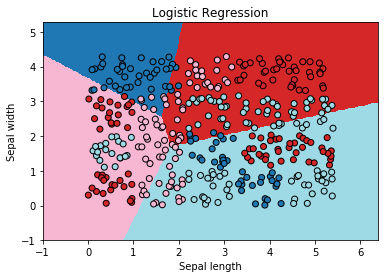

In [7]:
ax = draw_border(clr, X, Y, incx=1, incy=1, figsize=(6, 4), border=False)
ax.set_title("Logistic Regression");

Not quite close!

## Logistic Regression and k-means

In [8]:
from mlinsights.mlmodel import ClassifierAfterKMeans

clk = ClassifierAfterKMeans(e_solver="lbfgs", e_multi_class="multinomial")
clk.fit(X, Y)

c:\python370_x64\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


ClassifierAfterKMeans(c_algorithm='auto', c_copy_x=True, c_init='k-means++',
           c_max_iter=300, c_n_clusters=2, c_n_init=10, c_n_jobs=None,
           c_precompute_distances='auto', c_random_state=None,
           c_tol=0.0001, c_verbose=0, e_C=1.0, e_class_weight=None,
           e_dual=False, e_fit_intercept=True, e_intercept_scaling=1,
           e_max_iter=100, e_multi_class='multinomial', e_n_jobs=None,
           e_penalty='l2', e_random_state=None, e_solver='lbfgs',
           e_tol=0.0001, e_verbose=0, e_warm_start=False)

The centers of the first k-means:

In [9]:
clk.clus_[0].cluster_centers_

array([[3.26205371, 1.08211905],
       [1.06113799, 3.78383125]])

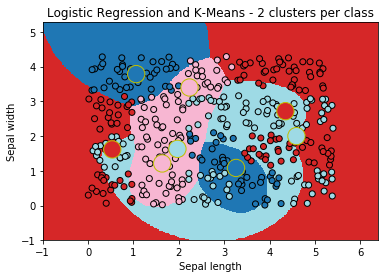

In [10]:
ax = draw_border(
    clk, X, Y, incx=1, incy=1, figsize=(6, 4), border=False, clusters=clk.clus_
)
ax.set_title("Logistic Regression and K-Means - 2 clusters per class");

The big cricles are the centers of the k-means fitted for each class. It look better!

## Variation

In [11]:
dt = []
for cl in range(1, 6):
    clk = ClassifierAfterKMeans(
        c_n_clusters=cl, e_solver="lbfgs", e_multi_class="multinomial", e_max_iter=700
    )
    clk.fit(X, Y)
    sc = clk.score(X, Y)
    dt.append(dict(score=sc, nb_clusters=cl))
import pandas

pandas.DataFrame(dt)

,nb_clusters,score
0,1,0.4475
1,2,0.6600
2,3,0.7475
3,4,0.8400
4,5,0.9200


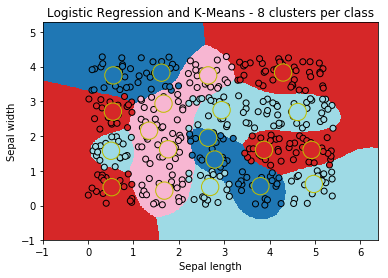

In [12]:
ax = draw_border(
    clk, X, Y, incx=1, incy=1, figsize=(6, 4), border=False, clusters=clk.clus_
)
ax.set_title("Logistic Regression and K-Means - 8 clusters per class");

## Random Forest

The random forest works without any clustering as expected.

In [13]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=20)
rf.fit(X, Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

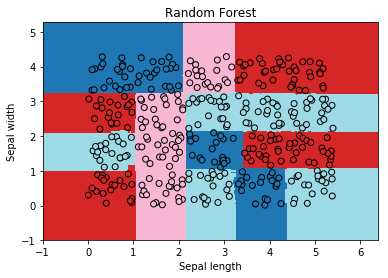

In [14]:
ax = draw_border(rf, X, Y, incx=1, incy=1, figsize=(6, 4), border=False)
ax.set_title("Random Forest");